In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
caracteristiques = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/e22ba475-45a3-46ac-a0f7-9ca9ed1e283a', sep=';')
lieux = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/2ad65965-36a1-4452-9c08-61a6c874e3e6', sep=';')
vehicules = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/780cd335-5048-4bd6-a841-105b44eb2667', sep=';')
usagers = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/36b1b7b3-84b4-4901-9163-59ae8a9e3028', sep=';')

# Fusion des bases

In [31]:
data = (usagers.merge(vehicules, on='id_vehicule', suffixes=(None, '_2'))
               .merge(caracteristiques, on='Num_Acc', suffixes=(None, '_3'))
               .merge(lieux, on='Num_Acc')
               .replace(-1, np.nan))
data.head()

,Num_Acc,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,...,prof,pr,pr1,plan,lartpc,larrout,surf,infra,situ,vma
0,201900000001,138 306 524,B01,2,2,4,2,2002,0.0,1.0,...,1.0,6,900,2.0,NaN,NaN,1.0,2.0,1.0,70.0
1,201900000001,138 306 524,B01,1,1,4,2,1993,5.0,1.0,...,1.0,6,900,2.0,NaN,NaN,1.0,2.0,1.0,70.0
2,201900000001,138 306 525,A01,1,1,1,1,1959,0.0,1.0,...,1.0,6,900,2.0,NaN,NaN,1.0,2.0,1.0,70.0
3,201900000002,138 306 523,A01,1,1,4,2,1994,0.0,1.0,...,4.0,3,845,2.0,NaN,NaN,1.0,0.0,1.0,70.0
4,201900000003,138 306 520,A01,1,1,1,1,1996,0.0,1.0,...,1.0,10,500,3.0,NaN,NaN,1.0,0.0,1.0,90.0


## Suppression des identifiants et variables avec trop de valeurs manquantes

On supprime tous les identifiants, sauf celui des usagers (plus l'année, qui est la même pour tous les accidents de la base)

In [32]:
data.drop(inplace=True, columns=['Num_Acc', 'id_vehicule', 'num_veh', 'Num_Acc_2', 'num_veh_2', 'an'])

On supprime également les variables avec trop de valeurs manquantes (identifiées dans `merge-exploration.ipynb`)

In [33]:
data.drop(inplace=True, columns=['lartpc', 'larrout', 'occutc','v2' ,'v1' ,'voie' ,'adr', 'trajet', 'secu2', 'secu3', 'locp', 'actp', 'etatp'])

# Transformation des variables

## Variables catégorielles

On transforme les variables catégorielles en suite d'indicatrices :

In [34]:
# Les variables dont le nom est précédé d'un underscore seront supprimées afin que la matrice des données soit inversible
categories = {
    'place': {"À l'avant du véhicule": [1,2,6],
              "À l'arrière du véhicule": [3,4,5],
              '_Au milieu du véhicule': [7,8,9]},
    'catu': {'Conducteur': [1],
             '_Passager': [2],
             'Piéton': [3]},
    'grav': {'Indemne': [1],
             'Tué': [2],
             'Blessé hospitalisé': [3],
             'Blessé léger': [4]},
    'sexe': {'_Homme': [1],
             'Femme': [2]},
    'secu1': {'_Aucun équippement': [0],
              'Ceinture': [1],
              'Casque': [2],
              'Dispositif enfant': [3],
              'Gilet réflechissant': [4],
              'Airbag': [5,7],
              'Gants': [6,7]},
    'senc': {'_Sens de circulation croissant': [1],
             'Sens de circulation décroissant': [2]},
    'catv': {'Deux-roues non-motorisé':[1,60],
             'Deux-roues motorisé': [2,30,31,32,33,34,41,42,43,50,80],
             'Trois-roues': [50,80],
             'Poids lourd': [13,14,15,16,17,21],
             'Transport en commun': [37,38,39,40],
             '_Véhicule léger': [3,7,10,35,36],
             'Engin spécial': [20]},
    'obs': {"_Pas d'obstacle fixe": [0,16],
            'Obstacle : Véhicule en stationnement': [1],
            'Obstacle : Arbre': [2],
            'Obstacle : Glissière métallique': [3],
            'Obstacle : Glissière en béton': [4],
            'Obstacle : Autre glissière': [5],
            'Obstacle : Bâtiment, mur, pile de pont': [6],
            'Obstacle : Support de signalisation ou poste d\'appel d\'urgence': [7],
            'Obstacle : Poteau': [8],
            'Obstacle : Mobilier urbain': [9],
            'Obstacle : Parapet': [10],
            'Obstacle : Ilot, refuge, borne haute': [11],
            'Obstacle : Bordure de trottoir': [12],
            'Obstacle : Fossé, talus, paroi rocheuse': [13],
            'Obstacle : Autre obstacle fixe sur chaussée': [14],
            'Obstacle : Autre obstacle fixe hors chaussée': [15],
            'Obstacle : Buse, tête d\'aqueduc': [17]},
    'obsm' : {"_Pas d'obstacle mobile": [0],
              "Obstacle : Piéton": [1],
              "Obstacle : Véhicule en mouvement": [2],
              "Obstacle : Véhicule sur rail": [4],
              "Obstacle : Animal": [5,6],
              "Obstacle : Autre obstacle mobile": [9]},
    'choc': {"_Pas de choc": [0],
             "Choc à l'avant": [1,2,3],
             "Choc à l'arrière": [4,5,6],
             "Choc latéral": [7,8],
             "Chocs multiples": [9]},
    'manv': {"_Sans changement de direction": [1,2],
             "Entre deux files": [3],
             "En marche arrière": [4],
             "À contresens": [5],
             "En franchissant le terre-plein": [6],
             "Dans le couloir de bus, même sens": [7],
             "Dans le couloir de bus, contresens": [8],
             "En s'insérant": [9],
             "En faisant demi-tour": [10],
             "Changement de file": [11,12],
             "Déporté": [13,14],
             "En tournant": [15,16],
             "En dépassant": [17,18],
             "En traversant la chaussée": [19],
             "En manoeuvrant pour stationner": [20],
             "Pendant une manoeuvre d'évitement": [21],
             "En ouvrant une porte": [22],
             "À l'arrêt": [23],
             "En stationnement": [24],
             "En circulant sur le trottoir": [25]},
    'motor': {"Moteur à hydrocarbures": [1],
              "Moteur hybride": [2],
              "Moteur électrique": [3],
              "_Moteur à hydrogène": [4],
              "Propulsion humaine": [5]},
    'lum': {"_Plein jour": [1],
            "Crépuscule ou aube": [2],
            "Nuit sans éclairage": [3,4],
            "Nuit avec éclairage": [5]},
    'agg': {"_Hors agglomération": [1],
            "En agglomération": [2]},
    'int': {"_Hors intersection": [1],
            "Intersection en X": [2],
            "Intersection en T": [3],
            "Intersection en Y": [4],
            "Intersection à plus de 4 branches": [5],
            "Giratoire": [6],
            "Place": [7],
            "Passage à niveau": [8],
            "Autre intersection": [9]},
    'atm': {"_Conditions atmosphériques normales": [1],
            "Pluie légère": [2],
            "Pluie forte": [3],
            "Neige ou grêle": [4],
            "Brouillard ou fumée": [5],
            "Vent fort ou tempête": [6],
            "Temps éblouissant": [7],
            "Temps couvert": [8],
            "Autres conditions atmosphériques": [9]},
    'col': {"Collision frontale (2 véhicules)": [1],
            "Collision par l'arrière (2 véhicules)": [2],
            "Collision par le côté (2 véhicules)": [3],
            "Collision en chaîne (3 véhicules ou plus)": [4],
            "Collisions multiples (3 véhicules ou plus)": [5],
            "Autre collision": [6],
            "_Sans collision": [7]},
    'catr': {"Autoroute": [1],
             "Route nationale": [2],
             "Route départementale": [3],
             "Voie communale": [4],
             "_Hors réseau public": [5],
             "Parc de stationnement": [6],
             "Routes de métropole urbaine": [7]},
    'circ': {"Circulation à sens unique": [1],
             "Circulation bidirectionnelle": [2],
             "Circulation à chaussées séparées": [3],
             "_Circulation avec voies d'affectation variables": [4]},
    'vosp': {"Présence d'une voie piste/bande cyclable": [1,2],
             "Présence d'une voie réservée": [3]},
    'prof': {"_Route plate": [1],
             "Route en pente": [2],
             "Sommet de côte": [3],
             "Bas de côte": [4]},
    'plan': {"_Route droite": [1],
             "En virage": [2,3],
             "En 'S'": [4]},
    'surf': {"_Surface normale": [1],
             "Surface mouillée": [2,3],
             "Chaussée inondée": [4],
             "Chaussée enneigée": [5],
             "Chaussée boueuse": [6],
             "Chaussé verglacée": [7],
             "Présence d'un corps gras sur la chaussée": [8],
             "Autre état de la chaussée": [9]},
    'infra': {"_Aucune infrastructure spéciale": [0],
              "Souterrain, tunnel": [1],
              "Pont, autopont": [2],
              "Bretelle d'échangeur ou de raccordement": [3],
              "Voie ferrée": [4],
              "Carrefour aménagé": [5],
              "Zone piétonne": [6],
              "Zone de péage": [7],
              "Chantier": [8],
              "Autre type d'infrastructure": [9]},
    'situ': {"_Sur chaussée": [1],
             "Sur bande d'arrêt d'urgence": [2],
             "Sur accotement": [3],
             "Sur trottoir": [4],
             "Sur piste cyclable": [5],
             "Sur autre voie spéciale": [6],
             "Autre lieu": [8]}
}

In [35]:
for var, mods in categories.items():
    for label, values in mods.items():
        data[label] = data[var].isin(values).astype(int)
    data.drop(inplace=True, columns=[var])
data.head()

,an_nais,jour,mois,hrmn,dep,com,lat,long,nbv,pr,...,Zone de péage,Chantier,Autre type d'infrastructure,_Sur chaussée,Sur bande d'arrêt d'urgence,Sur accotement,Sur trottoir,Sur piste cyclable,Sur autre voie spéciale,Autre lieu
0,2002,30,11,01:30,93,93053,"48,8962100","2,4701200",10.0,6,...,0,0,0,1,0,0,0,0,0,0
1,1993,30,11,01:30,93,93053,"48,8962100","2,4701200",10.0,6,...,0,0,0,1,0,0,0,0,0,0
2,1959,30,11,01:30,93,93053,"48,8962100","2,4701200",10.0,6,...,0,0,0,1,0,0,0,0,0,0
3,1994,30,11,02:50,93,93066,"48,9307000","2,3688000",2.0,3,...,0,0,0,1,0,0,0,0,0,0
4,1996,28,11,15:15,92,92036,"48,9358718","2,3191744",8.0,10,...,0,0,0,1,0,0,0,0,0,0


On vérifie que les regroupements de modalités ne sont pas (trop) déséquilibrés

In [36]:
for var, mods in categories.items():
    if var != 'grav':
        df = pd.DataFrame(index=mods, columns=['Observations'], data=[data[mod].value_counts()[1] for mod in mods])
        print(var.upper(), df, sep='\n', end='\n\n')

PLACE
                         Observations
À l'avant du véhicule          112605
À l'arrière du véhicule          5594
_Au milieu du véhicule           3513

CATU
            Observations
Conducteur         97356
_Passager          24356
Piéton             11265

SEXE
        Observations
_Homme         90384
Femme          42593

SECU1
                     Observations
_Aucun équippement           7196
Ceinture                    80550
Casque                      24377
Dispositif enfant             931
Gilet réflechissant            93
Airbag                        147
Gants                         112

SENC
                                 Observations
_Sens de circulation croissant          58983
Sens de circulation décroissant         44431

CATV
                         Observations
Deux-roues non-motorisé          5409
Deux-roues motorisé             25287
Trois-roues                       995
Poids lourd                      3635
Transport en commun              2136
_Véhicule 

In [37]:
data.drop(inplace=True, columns=[variable for variable in data.columns.tolist() if variable.startswith('_')])
data.head()

,an_nais,jour,mois,hrmn,dep,com,lat,long,nbv,pr,...,Zone piétonne,Zone de péage,Chantier,Autre type d'infrastructure,Sur bande d'arrêt d'urgence,Sur accotement,Sur trottoir,Sur piste cyclable,Sur autre voie spéciale,Autre lieu
0,2002,30,11,01:30,93,93053,"48,8962100","2,4701200",10.0,6,...,0,0,0,0,0,0,0,0,0,0
1,1993,30,11,01:30,93,93053,"48,8962100","2,4701200",10.0,6,...,0,0,0,0,0,0,0,0,0,0
2,1959,30,11,01:30,93,93053,"48,8962100","2,4701200",10.0,6,...,0,0,0,0,0,0,0,0,0,0
3,1994,30,11,02:50,93,93066,"48,9307000","2,3688000",2.0,3,...,0,0,0,0,0,0,0,0,0,0
4,1996,28,11,15:15,92,92036,"48,9358718","2,3191744",8.0,10,...,0,0,0,0,0,0,0,0,0,0


Il faut encore s'occuper des variables non-catégorielles : `an_nais`, `jour`, `mois`, `hrmn`, `dep`, `com`, `lat`, `long`, `nbv`, `pr`, `pr1` et `vma`

## Variables non-catégorielles

### Jour, mois, heure et minute

In [38]:
data['heure'] = data.hrmn.str[:2].astype(int)
data['minute'] = data.hrmn.str[3:].astype(int)
data.drop(inplace=True, columns='hrmn')

<AxesSubplot:>

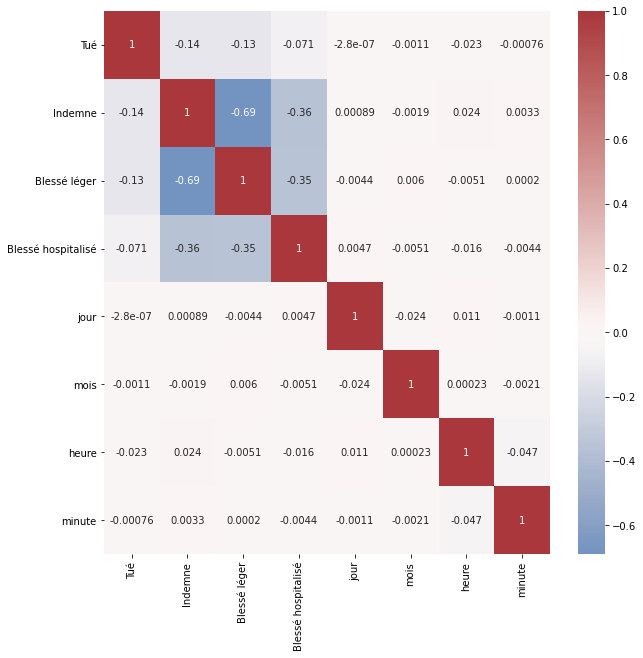

In [39]:
corr = data[['Tué', 'Indemne', 'Blessé léger', 'Blessé hospitalisé', 'jour', 'mois', 'heure', 'minute']].corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data=corr, annot=corr, cmap='vlag', center=0)

`jour`, `mois` et `minute` ont une corrélation très faible (<.01) avec les variables d'intérêt. On peut donc les exclure de l'analyse.

In [40]:
data.drop(inplace=True, columns=['jour', 'mois', 'minute'])

### Vitesse maximale autorisée (`vma`)

On élimine les valeurs erronées pour la vitesse (cf `stats-descriptives.ipynb`, cellule 9) :

In [41]:
na_values = [-1,0,1,2,3,4,6,7,12,500,600,700,800,5,10,42,560,np.nan]
print(data.shape)
data = data[~data.vma.isin(na_values)]
print(data.shape)

(132977, 144)
(130638, 144)


(Cela n'a supprimé que 40 observations soit moins de 0,03% de l'échantillon)

Pour les valeurs restantes, on fabrique des indicatrices :

In [42]:
for lim in data.vma.unique().tolist():
    data[f'Vitesse limitée à {int(lim)}km/h'] = (data.vma==lim).astype(int)
data.drop(inplace=True, columns='vma')

### Année de naissance

In [43]:
data.an_nais.nunique()

104

Transformer cette variable en suite d'indicatrices augmenterait grandement la dimension de la matrice des données, on crée plutôt des classes d'âges :

In [44]:
data['age'] = 2019 - data.an_nais

In [45]:
data.age.min(), data.age.max()

(0, 119)

In [46]:
for age_min, age_max in [(0,19), (20,39), (40,59), (60,74), (75,120)]:
    data[f'{age_min}-{age_max}ans'] = ( (data.age>=age_min) & (data.age<=age_max) ).astype(int)
data.drop(inplace=True, columns=['age', 'an_nais'])

### Localisation (`dep`, `com`, `long`, `lat`)

Ces variables sont-elles vraiment explicatives de l'issue de l'accident ?

In [47]:
data['lat'] = data.lat.str.replace(',','.').astype(float)
data['long'] = data.long.str.replace(',','.').astype(float)

<AxesSubplot:>

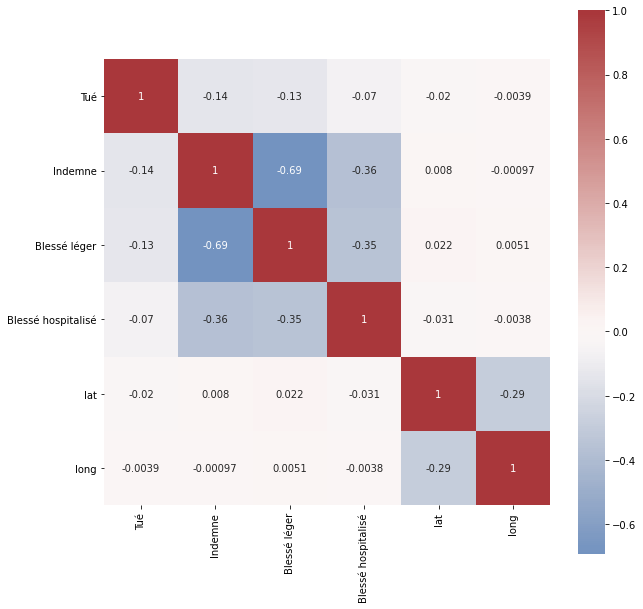

In [48]:
corr = data[['Tué', 'Indemne', 'Blessé léger', 'Blessé hospitalisé', 'lat', 'long']].corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data=corr, annot=corr, cmap='vlag', center=0, square=True)

(Il est impossible de calculer la corrélation pour `com` et `dep` car on en peut pas les transformer en variables numériques. J'avoue que je ne sais pas quoi faire de ces variables du coup. Les transformer en indicatrices me sembre une très mauvaise idée compte tenu du nombre de communes...)

Là aussi, correlation très faible avec les variables d'intérêt. Est-ce que ça vaut le coup de les garder ? À titre de comparaison, les corrélations avec le port de la ceinture et le fait que l'accident ait eu lieu en agglomération :

<AxesSubplot:>

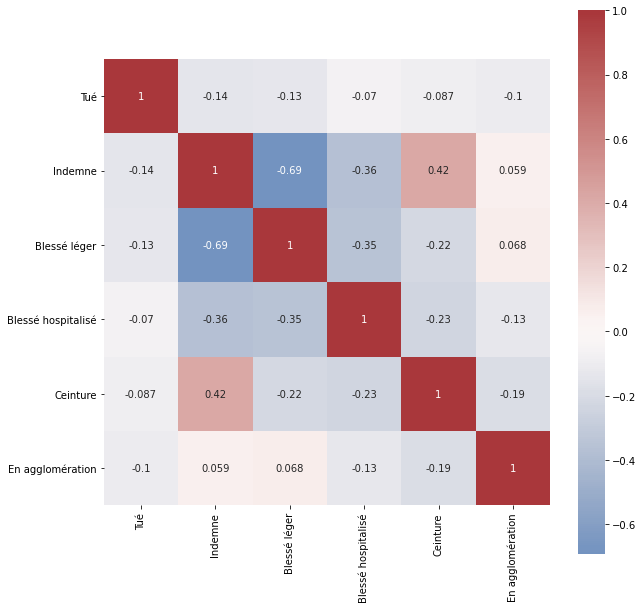

In [49]:
corr = data[['Tué', 'Indemne', 'Blessé léger', 'Blessé hospitalisé', 'Ceinture', 'En agglomération']].corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data=corr, annot=corr, cmap='vlag', center=0, square=True)

=> On ignore les 4

In [50]:
data.drop(inplace=True, columns=['lat', 'long', 'com', 'dep'])

### Nombre de voies (`nbv`)

In [51]:
for number in range(1,13):
    data[f'{number} voies de circulation'] = (data.nbv==number).astype(int)
data.drop(inplace=True, columns='nbv')

### Numéro et distance de la borne amont (`pr` et `pr1`)

Comme pour les autres variables géographiques, non pertinentes.

In [52]:
data.drop(inplace=True, columns=['pr', 'pr1'])

# Création du nouveau fichier

In [53]:
data.to_csv('DummiesV2.csv', index=False)

In [54]:
len(data.columns)

169